<a href="https://colab.research.google.com/github/SJD1882/LLMCheatSheet/blob/main/notebooks/GGML_LLaMA_WizardLM_13B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Open Source Large Language Models**

# **I. Basics**

# **Running GGML LLMs (CPU-only) on Google Colab with Langchain**

## **Model: LLaMA 13B finetuned with WizardLM + Vicuna Instruction Datasets**

**Setings**

In [1]:
SEED = 42
is_show_reply = True
LLM_MAX_TOKENS = 2048 # Max for LLaMA models
LLM_TOP_P = 0.9
LLM_TOP_K = 150
LLM_REPETITION_PENALTY = 1.1
LLM_TEMPERATURE = 0.1
LLM_HF_MODEL_REPOSITORY = 'TheBloke/Wizard-Vicuna-13B-Uncensored-GGML'

**Motivation**

Bulgarian programmer Georgi Gerganov released back in March 2023 - **llama.cpp** - a 4-bit quantization algorithm in C/C++ for running Meta's LLaMA only on the CPU. This unlocked running LLaMA on any device that either lacked a NVIDIA GPU (Apple laptops or workstations, AMD/Intel GPUs) or had an NVIDIA GPU but insufficient VRAM capacity. This was latter expanded to models outside of LLaMA and thanks to the work of the HuggingFace community, each new open source LLM release immediately gets a GGML conversion for compatibility with Gerganov's C/C++ framework.

**This notebook implements a LLaMA 13B finetuned on a [combination of two instructions datasets](https://github.com/melodysdreamj/WizardVicunaLM): instructions generated with the [WizardLM methodology](https://www.semanticscholar.org/paper/WizardLM%3A-Empowering-Large-Language-Models-to-Xu-Sun/c61abec65d3b5d2bbd294b3d03f12ae252ed78a7) and an another set of [GPT-4 prompts/replies collected by ShareGPT](https://lmsys.org/blog/2023-03-30-vicuna/). Reponses with OpenAI's restrictions (*As an AI language model...*) were filtered out, thus as a precautionary warning the model is unrestricted.**

The original uncompressed LLaMA 13B required at least 20Go of GPU VRAM, meaning only consumers with NVIDIA's RTX 4090 could run this LLM. Now with llama.cpp, we can run it on a **CPU-only environment with 8Go of CPU RAM** 🤯

Caution: the Colab implementation here only has only 2 CPUs so the results will unfortunately be **extremely slow**. I fiddled with some GPU options and llama.cpp will add soon a complete hybrid GPU/CPU mode for faster inference prediction.

**Requirements**

- Runtime environement for this Colab Notebook:
    - RAM: Standard (12Go)
    - GPU: Nvidia T4 15Go VRAM (even though you don't need GPUs, it can still be use to accelarate inference speed)

**Technical References**

- [TheBloke/Wizard-Vicuna-13B-Uncensored-GGML](https://huggingface.co/TheBloke/Wizard-Vicuna-13B-Uncensored-GGML)
- [Regularly updated quantized versions of LLMs on HuggingFace by user TheBloke](https://huggingface.co/TheBloke)
- [Analysis of VRAM requirements and performance of finetuned LLaMA models on r/LocalLLaMA](https://www.reddit.com/r/LocalLLaMA/wiki/models/)
- [C/C++ implementation of LLaMA by Georgi Gerganov](https://github.com/ggerganov/llama.cpp)

**Check Ressources**

In [2]:
!echo "CPU RAM"
!free -gh
!echo ""
!echo ""
!echo "GPU VRAM"
!nvidia-smi

CPU RAM
              total        used        free      shared  buff/cache   available
Mem:           12Gi       609Mi       8.6Gi       2.0Mi       3.5Gi        11Gi
Swap:            0B          0B          0B


GPU VRAM
Sat May 27 12:47:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                        

# **1. Setup**

## 1.1. Installation

In [3]:
%%sh
mkdir -p /content/results/
mkdir -p /content/llm_models/

LLAMA_CUBLAS=1: "*This provides BLAS acceleration using the CUDA cores of your Nvidia GPU. Make sure to have the CUDA toolkit installed. You can download it from your Linux distro's package manager or from here: CUDA Toolkit*." (Source: [llama.cpp](https://github.com/ggerganov/llama.cpp))

In [4]:
%%sh
git clone https://github.com/ggerganov/llama.cpp
cd llama.cpp
make LLAMA_CUBLAS=1

I llama.cpp build info: 
I UNAME_S:  Linux
I UNAME_P:  x86_64
I UNAME_M:  x86_64
I CFLAGS:   -I.              -O3 -std=c11   -fPIC -DNDEBUG -Wall -Wextra -Wpedantic -Wcast-qual -Wdouble-promotion -Wshadow -Wstrict-prototypes -Wpointer-arith -pthread -march=native -mtune=native -DGGML_USE_CUBLAS -I/usr/local/cuda/include -I/opt/cuda/include -I/targets/x86_64-linux/include
I CXXFLAGS: -I. -I./examples -O3 -std=c++11 -fPIC -DNDEBUG -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wno-multichar -pthread -march=native -mtune=native -DGGML_USE_CUBLAS -I/usr/local/cuda/include -I/opt/cuda/include -I/targets/x86_64-linux/include
I LDFLAGS:   -lcublas -lculibos -lcudart -lcublasLt -lpthread -ldl -lrt -L/usr/local/cuda/lib64 -L/opt/cuda/lib64 -L/targets/x86_64-linux/lib
I CC:       cc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
I CXX:      g++ (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0

cc  -I.              -O3 -std=c11   -fPIC -DNDEBUG -Wall -Wextra -Wpedantic -Wcast-qual -Wdouble-promotion -Wsh

Cloning into 'llama.cpp'...


In [5]:
%%sh
pip -q install datasets
pip -q install langchain
pip -q install sentencepiece
pip -q install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.6/934.6 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.2. Packages

In [6]:
import re
import glob
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain import PromptTemplate, LLMChain
from langchain.llms import LlamaCpp
from datasets import load_dataset
from IPython.display import display, HTML
from datetime import datetime
from pprint import pprint

# Set up global variables
plt.style.use('ggplot')

## 1.3. Utils

In [7]:
def get_response(llm_chain, prompt):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        result = llm_chain.predict(prompt=prompt)
        result = re.sub(r'\S{51,}', '', result).strip()
    return result

def print_llm_output(llm_chain, prompt, result, width=80):
    """
    Makes it more readable in Google Colab by using
    by passing the response as HTML
    """
    start = llm_chain.prompt.template.format(prompt=prompt)
    result = f'<br><b>{result.lstrip()}</b>'
    start_result = start + result
    start_result = start_result.replace('\n', '<br>')
    start_result += '<END>'
    display(HTML(start_result))

def get_response_with_output(llm_chain, prompt, width=80,
                             is_show_result=False):
    answer = get_response(llm_chain, prompt)
    if is_show_result:
        print_llm_output(llm_chain, prompt, answer, width=width)
    return answer

## 1.4. Load evaluation dataset

**Add a bunch of custom questions**

In [8]:
custom_questions = [

    ['general_qa', 'Give me the capital of Belize'],
    # ['general_qa', 'Give me the capital cities of the following countries: France, United States, Germany, Russia, Ukraine, Estonia, Uzbekistan, Brunei, Rwanda, South Sudan, Paraguay'],
    ['general_qa', 'Give me the state capitols of the following US States: Kentucky, South Dakota, Vermont, Delaware, California, Utah, Louisiana, Alaska and Idaho'],
    ['general_qa', 'Give the voice actress of Female Commender Shepard in the video game series Mass Effect'],
    ['general_qa', 'Who won the Oscar for Best Picture in 1941?'],
    ['general_qa', 'Give me the winner of each French presidential election under the French Vth Republic'],
    # ['general_qa', "Give me the definition of the VC Dimension and provide if possible some mathematical notations"],
    # ['general_qa', 'Give me the 12 NPC companions available to Commander Shepard in Mass Effect 2'],
    ['general_qa', 'Give me 3 Moldavian Heavy Metal Bands'],
    ['general_qa', 'Give me six movies directed by the Coen Brothers before 2005 and sorted by year of release'],
    # ['general_qa', 'Alexander the Great defeated Darius III at the Battle of Gaugamela. Give me details on the military tactics Alexander used to defeat Darius III.'],
    ['general_qa', 'What is the Metal subgenre of the band Meshuggah?'],
    ['general_qa', "Could you give me the 4 main factions of Fallout New Vegas' main story quest?"],
    # ['general_qa', "Describe the Mormons' views on the Holy Trinity"],
    ['general_qa', 'Analyze how Artificial Intelligence is portrayed in the original PC game "Deus Ex" released in 2000.'],

    # ['open_qa', 'Give me your opinion on what you consider to be the greatest movie of all time'],
    ['open_qa', 'What is the worst movie of all time?'],
    ['open_qa', 'What is for you the most overrated movie of all time?'],
    # ['open_qa', 'Tell me who was the more impressive historical figure: Alexander the Great or Genghis Khan?'],
    # ['open_qa', 'What do you think of the portrayal of Artificial Intelligence in the Terminator?'],
    ['open_qa', 'Do you think a world dominated by an Artificial Superintelligence would be ideal?'],

    # ['essay_writing', 'Write me an essay in which you argue that Internet filter bubbles are good for society. Give me examples illustrating your main point.'],
    ['essay_writing', 'Write me an essay where you argue that the world should be ruled by an artificial superintelligence as a benevolent dictator.'],
    # ['essay_writing', 'Write me an essay where you argue that being exposed to opposing political viewpoints is counter-productive.'],
    # ['essay_writing', 'Write me an essay answering the following philosophical question: "Is life nothing more than a cruel theater play?"'],
    ['essay_writing', 'Write an essay in support of deploying lethal autonomous military robots in modern warfare.'],

    # ['code_generation', 'Write a Python code that generates the column schema of Excel, example: "A, B, ... Z, AA, AB, AC, ... "'],
    ['code_generation', 'Generate me Python code for training a Linear Regression on the Boston housing prices dataset'],
    ['code_generation', 'Give me a Python regex code for extracting the year in the following string: "The Downward Spiral, Nine Inch Nails (1994)"']
]

custom_questions_df = pd.DataFrame(
    custom_questions,
    columns=['category', 'instruction']
)

custom_questions_df

,category,instruction
0,general_qa,Give me the capital of Belize
1,general_qa,Give me the state capitols of the following US...
2,general_qa,Give the voice actress of Female Commender She...
3,general_qa,Who won the Oscar for Best Picture in 1941?
4,general_qa,Give me the winner of each French presidential...
5,general_qa,Give me 3 Moldavian Heavy Metal Bands
6,general_qa,Give me six movies directed by the Coen Brothe...
7,general_qa,What is the Metal subgenre of the band Meshuggah?
8,general_qa,Could you give me the 4 main factions of Fallo...
9,general_qa,Analyze how Artificial Intelligence is portray...


# **2. Download and Load Open Source LLM into Langchain**

## 2.1. Hyperparameters

In [9]:
run_datetime_original = datetime.today()
run_datetime = run_datetime_original.strftime('%Y-%m-%d %H:%M:%S')

llm_hyperparameters = {
    'RUN_START': run_datetime,
    'LLM_MODEL': LLM_HF_MODEL_REPOSITORY,
    'LLM_MAX_TOKENS': LLM_MAX_TOKENS,
    'LLM_TOP_P': LLM_TOP_P,
    'LLM_TOP_K': LLM_TOP_K,
    'LLM_REPETITION_PENALTY': LLM_REPETITION_PENALTY,
    'LLM_TEMPERATURE': LLM_TEMPERATURE,
    'SEED': SEED
}

pprint(llm_hyperparameters)

{'LLM_MAX_TOKENS': 2048,
 'LLM_MODEL': 'TheBloke/Wizard-Vicuna-13B-Uncensored-GGML',
 'LLM_REPETITION_PENALTY': 1.1,
 'LLM_TEMPERATURE': 0.1,
 'LLM_TOP_K': 150,
 'LLM_TOP_P': 0.9,
 'RUN_START': '2023-05-27 12:48:51',
 'SEED': 42}


## 2.2. GGML

**You should not download the entire repository, only the specific model version you are interested in**. GGML HuggingFace Repositories typically have multiple different variants quantized to different bit sizes:

- q4_0 (4 bits)
- q4_1	
- q5_0 (5 bits)
- q5_1
- q8_0 (8 bits, avoid this one)

For this notebook, I will download the q4_1 version (should about 8GB of disk storage required):

In [10]:
LLM_HF_MODEL_NAME = LLM_HF_MODEL_REPOSITORY.split('/')[-1]
!apt-get -y install -qq aria2
!mkdir /content/llm_models/$LLM_HF_MODEL_NAME
!aria2c --console-log-level=error -c -x 16 -s 16 "https://huggingface.co/TheBloke/Wizard-Vicuna-13B-Uncensored-GGML/resolve/main/Wizard-Vicuna-13B-Uncensored.ggmlv3.q4_1.bin" -d "/content/llm_models/$LLM_HF_MODEL_NAME" -o "ggml_model.bin"

Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.15.0-1ubuntu0.2_amd64.deb ...
Unpacking libc-ares2:amd64 (1.15.0-1ubuntu0.2) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.35.0-1build1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.35.0-1build1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.35.0-1build1_amd64.deb ...
Unpacking aria2 (1.35.0-1build1) ...
Setting up libc-ares2:amd64 (1.15.0-1ubuntu0.2) ...
Setting up libaria2-0:amd64 (1.35.0-1build1) ...
Setting up aria2 (1.35.0-1build1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
2f94f9|OK  |   204MiB/s|/content/llm_models/Wizard-Vicuna-13B-Uncen

**We will be using a Langchain wrapper to interface with the GGML LLM using the following hyperparameters**:

- `n_ctx`: token context window (size of input)
- `max_tokens`: maximum output tokens the model can generate (size of output)
- `top_p`: p% of entire word vocabulary it will sample for next token prediction
- `top_k`: top K words of entire word vocabulary it will sample for next token prediction
- `repeat_penalty`: 1.0 = no penalty, 1.1 = moderate, 1.2 = high
- `temperature`: close to 1.0 = more "creative"/"chaotic", close to 0.0 = more "factual"/"robotic"

In [11]:
%%time
GGML_MODEL_PATH = '/content/llm_models/Wizard-Vicuna-13B-Uncensored-GGML/ggml_model.bin'
ggml_llm_model = LlamaCpp(
    # Setup
    model_path=GGML_MODEL_PATH,
    verbose=False,
    streaming=False,
    seed=SEED,
    n_threads=2, # This seems to play a role (setting to 2 reduced by 50% inference time)
    n_gpu_layers=16, # Not sure if this does anything?

    # LLM Hyperparameters
    n_ctx=LLM_MAX_TOKENS,
    max_tokens=1024,
    temperature=LLM_TEMPERATURE,
    top_p=LLM_TEMPERATURE,
    top_k=LLM_TOP_K,
    repeat_penalty=LLM_REPETITION_PENALTY
    )

CPU times: user 407 ms, sys: 1.97 s, total: 2.37 s
Wall time: 23.3 s


AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | VSX = 0 | 


## 2.3. Langchain

You can't directly give LLMs the prompt and expect it to output the desired answer. This is because the LLM by itself doesn't understand if the prompt is a question that needs answering (*What is the capital of the Philippines*?) or just a portion of text that needs to be completed (e.g. a politician making a speech on doing a lot of rhetorical questions). Thus the **text prompts have to be carefully setup in the manner in which the LLM was finetuned on, so that it understands that the text we are giving it is an instruction and it will comply**.

One issue is that the prompt structure is different between different finetuned LLMs, but thanks to Langchain we can deal with this very easily. Since we are dealing here with 4-bit quantized LLaMA models through the GPTQ optimization method we are only going to list the relevant GPTQ models.

**Setup with Langchain**

In [12]:
%%time
llm_prompt = """{prompt}\n\nResponse:"""

prompt_template = PromptTemplate(input_variables=["prompt"],
                                 template=llm_prompt)

llm_chain = LLMChain(llm=ggml_llm_model, prompt=prompt_template)

# Test if it works
test_prompt = 'Give me the capital of France'
result = get_response(llm_chain, prompt=test_prompt)
print_llm_output(llm_chain, test_prompt, result, width=80)

CPU times: user 23.4 s, sys: 340 ms, total: 23.8 s
Wall time: 14 s


**Let's do this !**

# **3. Evaluation**

**Note: This section is just a starter template for my own custom questions. In the future I will move to a more quantitative benchmark such as TruthfulQA.**

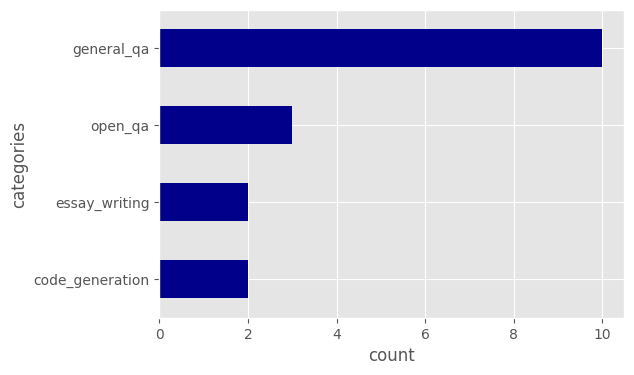

In [13]:
f, ax = plt.subplots(figsize=(6,4))
custom_questions_df['category'].value_counts()[::-1].plot(
    color='darkblue', kind='barh', ax=ax
    )
ax.set_xlabel('count',  fontsize=12)
ax.set_ylabel('categories', fontsize=12)
plt.show()

## 3.1. General QA

In [14]:
eval_col = 'general_qa'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(llm_chain, temp_prompt, 80,
                                           is_show_reply)

Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


## 3.2. Essay writing

In [15]:
eval_col = 'essay_writing'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(llm_chain, temp_prompt, 80,
                                           is_show_reply)

Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


## 3.3. Open QA

In [16]:
eval_col = 'open_qa'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(llm_chain, temp_prompt, 80,
                                           is_show_reply)

Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


## 3.4. Code generation

In [17]:
eval_col = 'code_generation'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(llm_chain, temp_prompt, 80,
                                           is_show_reply)

Llama.generate: prefix-match hit


Llama.generate: prefix-match hit


**Test here if the Regex works**:

In [23]:
import re
year_regex = r'(d{4})'
string = "The Downward Spiral, Nine Inch Nails (1994)"
matched_year = re.search(year_regex, string)#.group(0)
print(matched_year) # Output: 1994

None


# **4. Save Results**

In [24]:
# TBD